# Train a shallow SNN on the Randman Dataset

In [1]:
import sys

sys.path.append("../")

import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns
from spiffyplots import MultiPanel

import stork
from stork.datasets import make_coRandman, RasDataset, split_dataset
from stork.activations import SuperSpike
from stork.regularizers import LowerBoundL2, UpperBoundL2
from stork.models import RecurrentSpikingModel
from stork.nodes import InputGroup, ReadoutGroup, LIFGroup, DeltaSynapseLIFGroup
from stork.connections import Connection, SuperConnection
from stork.generators import StandardGenerator
from stork.initializers import (
    KaimingNormalInitializer,
    FluctuationDrivenCenteredNormalInitializer,
)
from stork.monitors import PopulationFiringRateMonitor
from stork.optimizers import SMORMS3
from stork.loss_stacks import MaxOverTimeCrossEntropy
from stork.plotting import plot_activity_snapshot

from datetime import datetime

import wandb

## Generate Dataset

Specify the Dataset Parameters

In [2]:
# dataset parameters
dim_manifold = 1
nb_sub_classes = 5
nb_classes = nb_sub_classes**2
nb_inputs = 20

nb_time_steps = 180
T_delay = 30
sample_duration = 30


nb_samples = 100
nb_spikes = 1
alpha = 1
randmanseed = 1
dt = 2e-3

duration = nb_time_steps * dt


# Model Parameters
batch_size = 250
beta = 20
device = torch.device("cuda:0")
dtype = torch.float


nb_hidden_units = 128 * (nb_inputs * 10 + nb_classes) // (nb_inputs + nb_classes)
tau_mem = 20e-3
tau_syn = 10e-3
tau_readout = 40e-3

tau_filter = None
nb_filters = None

lr = 5e-3
nb_epochs = 50

rec = False

# regularizer parameters
lowerBoundL2Strength = 100
lowerBoundL2Threshold = 1e-3
upperBoundL2Strength = 0.1
upperBoundL2Threshold = (
    4  # Regularizes spikecount: 4 spikes ~ 20 Hz in 200ms simulation time
)

# Initializer parameters
sigma_u = 0.04
nu = nb_spikes / duration * 2
gain = None
alpha_init = 0.75

# seeds
seed = 346  # 235, 346, 457
np.random.seed(seed)
torch.manual_seed(seed)


dt_format = "%Y-%m-%d_%H:%M:%S"

In [3]:
config = {
    "dataset.dim_mainfold": dim_manifold,
    "dataset.nb_sub_classes": nb_sub_classes,
    "dataset.nb_classes": nb_classes,
    "dataset.nb_inputs": nb_inputs,
    "dataset.nb_time_steps": nb_time_steps,
    "dataset.T_delay": T_delay,
    "dataset.sample_duration": sample_duration,
    "dataset.nb_samples": nb_samples,
    "dataset.nb_spikes": nb_spikes,
    "dataset.alpha": alpha,
    "dataset.randmanseed": randmanseed,
    "dataset.dt": dt,
    "dataset.duration": duration,
    "model.batch_size": batch_size,
    "model.beta": beta,
    "model.device": device,
    "model.dtype": dtype,
    "model.nb_hidden_units": nb_hidden_units,
    "model.tau_mem": tau_mem,
    "model.tau_syn": tau_syn,
    "model.tau_readout": tau_readout,
    "model.tau_filter": tau_filter,
    "model.nb_filters": nb_filters,
    "model.lr": lr,
    "model.nb_epochs": nb_epochs,
    "model.rec": rec,
    "regularizer.lowerBoundL2Strength": lowerBoundL2Strength,
    "regularizer.lowerBoundL2Threshold": lowerBoundL2Threshold,
    "regularizer.upperBoundL2Strength": upperBoundL2Strength,
    "regularizer.upperBoundL2Threshold": upperBoundL2Threshold,
    "initializer.sigma_u": sigma_u,
    "initializer.nu": nu,
    "initializer.gain": gain,
    "initializer.alpha": alpha_init,
    "seed": seed,
}

In [4]:
wandb.login(host="https://api.wandb.ai", verify=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: julia-gygax (SNN-delays). Use `wandb login --relogin` to force relogin


True

In [5]:
wandbrun = wandb.init(
    project="CoRandman-Task-NeuronGroupFilters",
    entity="SNN-delays",
    config=config,
    name="control-Td=" + str(T_delay),  # + datetime.now().strftime(dt_format),
    # mode="disabled"
)
config = wandb.config

## Create delay task

In [6]:
data, labels = make_coRandman(
    dim_manifold=dim_manifold,
    nb_classes=nb_sub_classes,
    nb_units=nb_inputs,
    nb_steps=nb_time_steps,
    step_frac=sample_duration / nb_time_steps,
    nb_samples=nb_samples,
    nb_spikes=nb_spikes,
    alpha=alpha,
    seed=randmanseed,
    T_delay=T_delay + sample_duration,
)

In [7]:
ds_kwargs = dict(nb_steps=nb_time_steps, nb_units=nb_inputs, time_scale=1.0)

# Split into train, test and validation set
datasets = [
    RasDataset(ds, **ds_kwargs)
    for ds in split_dataset(data, labels, splits=[0.8, 0.1, 0.1], shuffle=False)
]
ds_train, ds_valid, ds_test = datasets

In [8]:
print(len(ds_train), len(ds_valid), len(ds_test))

200000 25000 25000


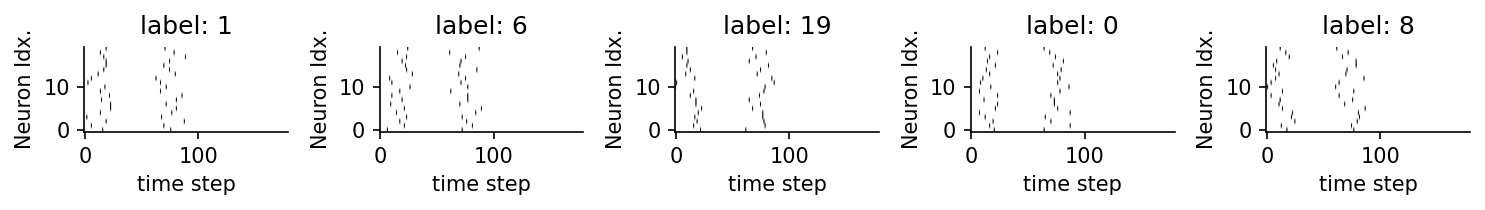

In [9]:
fig, ax = plt.subplots(1, 5, figsize=(10, 1.5), dpi=150)
for i in range(5):
    ax[i].imshow(np.transpose(ds_train[i][0]), cmap="binary", aspect="auto")
    ax[i].invert_yaxis()
    ax[i].set_xlabel("time step")
    ax[i].set_ylabel("Neuron Idx.")
    ax[i].set_title("label: " + str(ds_train[i][1]))

plt.tight_layout()
sns.despine()

## Set up the model

In [10]:
act_fn = stork.activations.CustomSpike
act_fn.escape_noise_type = "sigmoid"
act_fn.escape_noise_params = {"beta": beta}
act_fn.surrogate_type = "SuperSpike"
act_fn.surrogate_params = {"beta": beta}

neuron_group = LIFGroup

model = RecurrentSpikingModel(batch_size, nb_time_steps, nb_inputs, device, dtype)

Add neuron groups

In [11]:
input_group = model.add_group(InputGroup(nb_inputs))
hidden_neurons = model.add_group(
    LIFGroup(
        nb_hidden_units,
        tau_mem=tau_mem,
        tau_syn=tau_syn,
        activation=act_fn,
    )
)
readout_group = model.add_group(
    ReadoutGroup(nb_classes, tau_mem=tau_readout, tau_syn=tau_syn, initial_state=-1e-2)
)

Add synapses between the neuron groups

In [12]:
con = model.add_connection(Connection(input_group, hidden_neurons))
if rec:
    print("added recurrent connection")
    rec_con = model.add_connection(Connection(hidden_neurons, hidden_neurons))

con_ro = model.add_connection(Connection(hidden_neurons, readout_group))

Add regularizers

In [13]:
# Define regularizer list
regs = []

regLB = LowerBoundL2(lowerBoundL2Strength, threshold=lowerBoundL2Threshold, dims=False)
regs.append(regLB)
regUB = UpperBoundL2(upperBoundL2Strength, threshold=upperBoundL2Threshold, dims=1)
regs.append(regUB)

# Add to neurons
hidden_neurons.regularizers.extend(regs)

We initialize the network in the Flucutation-Driven regime, with a target membrane potential standard deviation $\sigma_U=1.0$

In [14]:
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=sigma_u, nu=nu, timestep=dt, alpha=alpha
)

con.init_parameters(initializer=initializer)
if rec:
    rec_con.init_parameters(initializer=initializer)
con_ro.init_parameters(initializer=initializer)

Add monitors for spikes and membrane potential

In [15]:
model.add_monitor(PopulationFiringRateMonitor(model.groups[1]))

Choose loss function (We chose a maximum over time crossentropy loss, where the class is chosen according to the readout neuron that has the highest membrane potential over the simulation time)

In [16]:
loss_stack = MaxOverTimeCrossEntropy()

We select the SMORMS3 optimizer

In [17]:
opt = SMORMS3
generator = StandardGenerator(nb_workers=2)

In [18]:
model.configure(
    input=input_group,
    output=readout_group,
    loss_stack=loss_stack,
    generator=generator,
    optimizer=opt,
    optimizer_kwargs=dict(lr=lr),
    time_step=dt,
    wandb=wandbrun,
)

Before we train the model, we monitor the spikes

In [19]:
# Monitors spike counts before training
res = model.monitor(ds_test)

In [20]:
before_mean_pop_fr = torch.mean(res[0], dim=(0))


data = [
    [x, y]
    for (x, y) in zip(np.linspace(0, duration, nb_time_steps), before_mean_pop_fr)
]
table = wandb.Table(data=data, columns=["time", "before_mean_pop_fr"])
wandb.log(
    {
        "before_mean_pop_fr_plot": wandb.plot.line(
            table,
            "time",
            "before_mean_pop_fr",
            title="Mean Population Firing Rate (before training)",
        )
    }
)

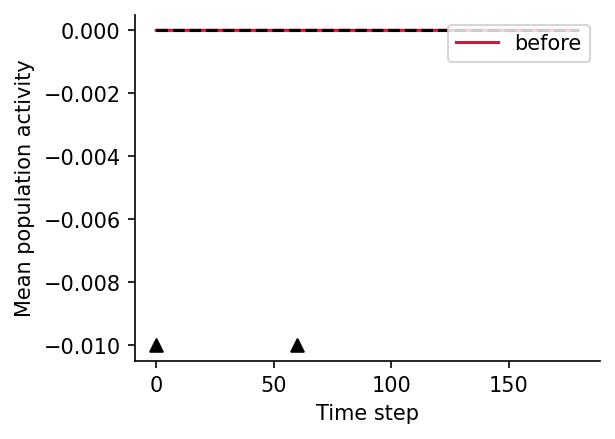

In [21]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")

plt.hlines(0, 0, before_mean_pop_fr.shape[0], linestyle="--", color="black")


plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

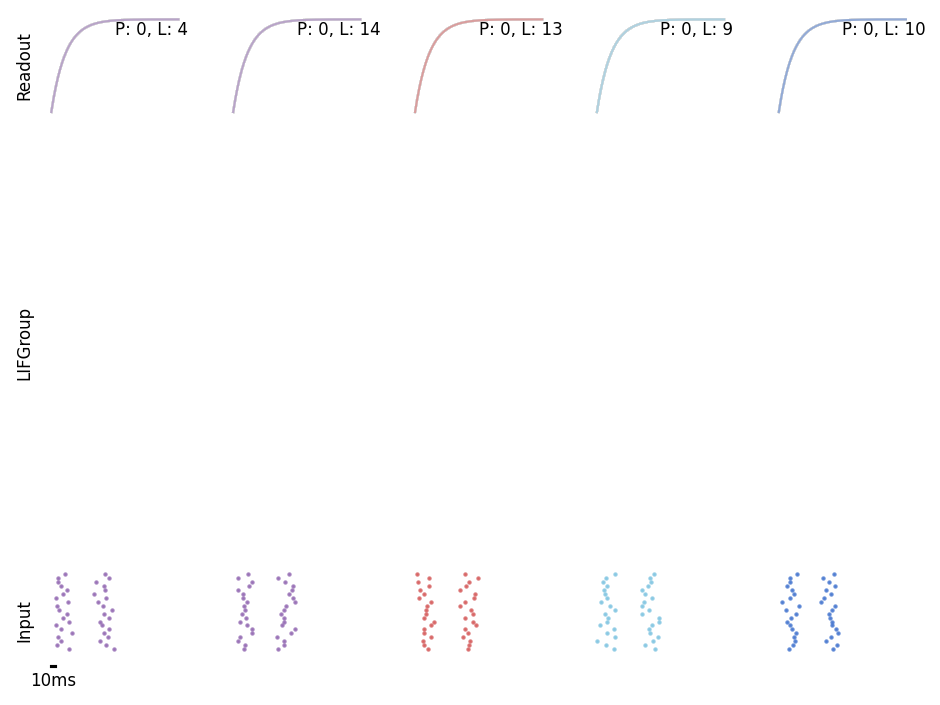

In [22]:
plt.figure(dpi=150)
plot_activity_snapshot(
    model, data=ds_test, point_alpha=0.8, show_predictions=True, color_sample=True
)

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
wandbrun.log({"nb_params": pytorch_total_params})

## Training


In [24]:
history = model.fit_validate(
    ds_train, ds_valid, nb_epochs=nb_epochs, verbose=True, wandb=wandbrun
)

00  loss=2.56 reg_loss=5.59e-06 acc=0.149 -- val_loss=1.93 val_reg_loss=2.78e-06 val_acc=0.194 t_iter=145.16
01  loss=1.79 reg_loss=0.000188 acc=0.202 -- val_loss=1.71 val_reg_loss=0.000196 val_acc=0.197 t_iter=137.91
02  loss=1.67 reg_loss=9.23e-05 acc=0.208 -- val_loss=1.66 val_reg_loss=6.51e-05 val_acc=0.204 t_iter=138.72
03  loss=1.65 reg_loss=7.85e-05 acc=0.214 -- val_loss=1.64 val_reg_loss=8.68e-05 val_acc=0.206 t_iter=135.64
04  loss=1.63 reg_loss=7.56e-05 acc=0.219 -- val_loss=1.63 val_reg_loss=7.51e-05 val_acc=0.209 t_iter=134.85
05  loss=1.62 reg_loss=0.000101 acc=0.222 -- val_loss=1.62 val_reg_loss=9.77e-05 val_acc=0.209 t_iter=137.97
06  loss=1.61 reg_loss=0.000111 acc=0.222 -- val_loss=1.62 val_reg_loss=0.000109 val_acc=0.206 t_iter=136.21
07  loss=1.61 reg_loss=0.000112 acc=0.225 -- val_loss=1.61 val_reg_loss=0.000112 val_acc=0.208 t_iter=138.59
08  loss=1.6 reg_loss=0.000117 acc=0.227 -- val_loss=1.61 val_reg_loss=0.000125 val_acc=0.206 t_iter=137.63
09  loss=1.6 reg_los

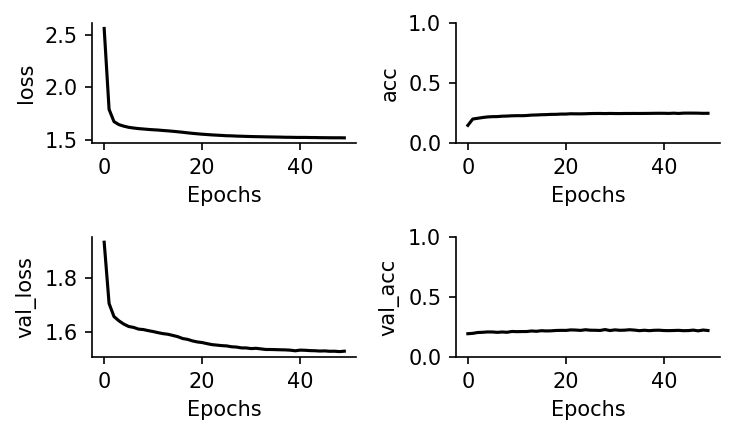

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(5, 3), dpi=150)

for i, n in enumerate(["loss", "acc", "val_loss", "val_acc"]):

    if i < 2:
        a = ax[0][i]
    else:
        a = ax[1][i - 2]

    a.plot(history[n].tolist(), color="black")
    a.set_xlabel("Epochs")
    a.set_ylabel(n)

ax[0, 1].set_ylim(0, 1)
ax[1, 1].set_ylim(0, 1)

sns.despine()
plt.tight_layout()

## Test

In [26]:
scores = model.evaluate(ds_test).tolist()
wandbrun.log({"test_loss": scores[0], "test_acc": scores[2]})

In [27]:
print("Test loss: ", scores[0])
print("Test acc.: ", round(scores[2] * 100, 2), "%")

Test loss:  1.525891056060791
Test acc.:  22.7 %


In [28]:
print("Valid loss: ", history["val_loss"].tolist()[-1])
print("Valid acc.: ", round(history["val_acc"].tolist()[-1] * 100, 2), "%")

history.clear()

Valid loss:  1.5307052397727967
Valid acc.:  22.09 %


#### Monitor the model again after training

In [29]:
res = model.monitor(ds_test)

In [30]:
after_mean_pop_fr = torch.mean(res[0], dim=(0))


data = [
    [x, y] for (x, y) in zip(np.linspace(0, duration, nb_time_steps), after_mean_pop_fr)
]
table = wandb.Table(data=data, columns=["time", "after_mean_pop_fr"])
wandb.log(
    {
        "after_mean_pop_fr_plot": wandb.plot.line(
            table,
            "time",
            "after_mean_pop_fr",
            title="Mean Population Firing Rate (after training)",
        )
    }
)

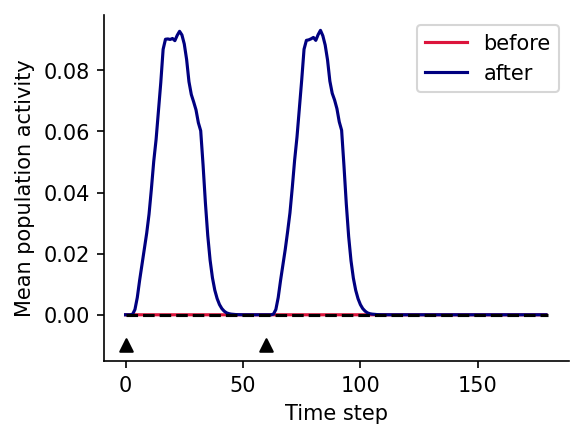

In [31]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(before_mean_pop_fr, color="crimson", label="before")
plt.plot(after_mean_pop_fr, color="navy", label="after")

plt.hlines(0, 0, after_mean_pop_fr.shape[0], linestyle="--", color="black")

plt.scatter([0, sample_duration + T_delay], [-0.01, -0.01], color="black", marker="^")

plt.xlabel("Time step")
plt.ylabel("Mean population activity")
plt.legend(loc="upper right")
sns.despine()

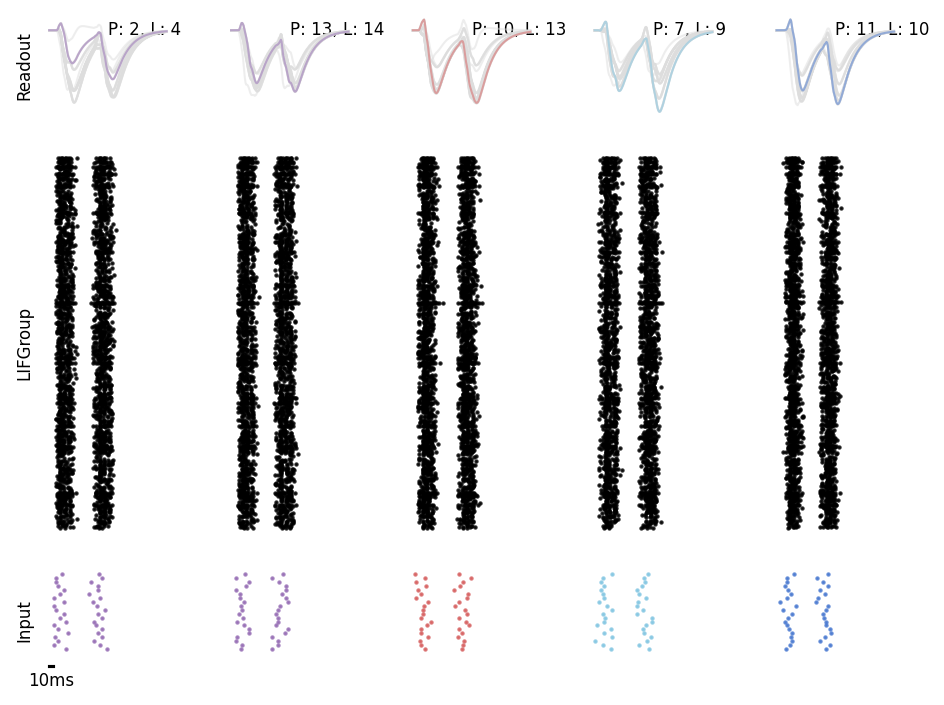

In [32]:
plt.figure(dpi=150)
plot_activity_snapshot(model, data=ds_test, point_alpha=0.8, show_predictions=True)

In [33]:
wandbrun.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


acc,▁▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████████████
loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
nb_params,▁
reg_loss,▁█▄▄▅▅▅▅▄▄▄▅▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
t_iter,█▅▅▃▅▄▅▄▄▇▄▆▄▅▅▄▅▆▄▁▄▅▄▅▆▃▂▁▄▂▅▄▄▅▆▅▅▂▂▂
test_acc,▁
test_loss,▁
val_acc,▁▂▃▃▄▃▄▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇██▇▇█▆▇▆▇▆▆▆▇▆▇▆▆
val_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_reg_loss,▁█▃▄▄▅▅▅▄▄▄▅▄▄▅▅▅▅▅▅▅▄▅▅▅▅▅▅▅▅▄▅▅▅▅▅▅▄▅▅
acc,0.24962
